# YouTube trending videos
Przedmiot: Projekt Eksploracji Danych<br>
Grupa:
* Kajetan Zimniak, 127229
* Bartosz Górka, 127228


## Wczytywanie danych
Projekt zakłada wykorzystanie repozytorium na platformie GitHub i synchronizację plików stanowiących zbiór danych

In [52]:
!git clone --branch feature/textual_attributes https://github.com/bartoszgorka/youtube-trending-videos.git

fatal: destination path 'youtube-trending-videos' already exists and is not an empty directory.


In [0]:
DATA = "youtube-trending-videos/youtube_data"

Sprawdzenie danych przechowywanych w folderze `DATA` (referencja na wcześniej pobrane repozytorium). W wyniku powinniśmy otrzymać listę następujących plików:
* `GB_category_id.json`
* `GB_videos_5p.csv`
* `US_category_id.json`
* `US_videos_5p.csv`

In [54]:
!ls $DATA

GB_category_id.json  GB_videos_5p.csv  US_category_id.json  US_videos_5p.csv


## Import
Import używanych przez program paczek dla języka Python

In [55]:
import os
import re
import json
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.apionly as sns
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Przygotowanie danych pod analizę
Wykorzystujemy `pandas` aby móc efektywnie przeszukiwać nasz zbiór danych zapisany w postaci `DataFrame`

Dane dotyczące kategorii również zostały zaprezentowane w postaci `DataFrame` (normalizacja z oryginalej postaci pliku `JSON`) aby móc ujednolicić wykorzystanie danych.

W przypadku kolumny `description` wymagane było dodatkowe skorygowanie jej nazwy (w pierwotnej występowały nadmiarowe spacje).



In [0]:
def read_and_parse_video_data(name):
    df = pd.read_csv(os.path.join(DATA, name), encoding='ISO-8859-1', sep=';')
    df.rename(inplace = True, columns = lambda x: x.strip())
    df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m')
    df['publish_time'] = pd.to_datetime(df['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ')
    df['category_id'] = df['category_id'].astype(str)
    return df

# --------------------------------- GB FILES ---------------------------------
with open(os.path.join(DATA, 'GB_category_id.json')) as json_file:
    GB_category_id = pd.io.json.json_normalize(data = json.load(json_file)['items'])

GB_videos_5p = read_and_parse_video_data('GB_videos_5p.csv')

# --------------------------------- US FILES ---------------------------------
with open(os.path.join(DATA, 'US_category_id.json')) as json_file:
    US_category_id = pd.io.json.json_normalize(data = json.load(json_file)['items'])

US_videos_5p = read_and_parse_video_data('US_videos_5p.csv')

Sprawdzimy teraz, jak prezentuje się ogólna struktura danych dla `GB`

In [57]:
def describe(df, name):
    print(name)
    print(df.info())
    print(df.describe())

describe(GB_category_id, 'GB_category_id')
describe(GB_videos_5p, 'GB_videos_5p')

GB_category_id
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 6 columns):
kind                  31 non-null object
etag                  31 non-null object
id                    31 non-null object
snippet.channelId     31 non-null object
snippet.title         31 non-null object
snippet.assignable    31 non-null bool
dtypes: bool(1), object(5)
memory usage: 1.4+ KB
None
                         kind  ... snippet.assignable
count                      31  ...                 31
unique                      1  ...                  2
top     youtube#videoCategory  ...              False
freq                       31  ...                 17

[4 rows x 6 columns]
GB_videos_5p
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38916 entries, 0 to 38915
Data columns (total 16 columns):
video_id                  38916 non-null object
trending_date             38916 non-null datetime64[ns]
title                     38916 non-null object
channel_title      

Jak możemy zaobserwować, w naszym zbiorze dla `GB` znajduje się 38916 przykładów. W przypadku 38304 mamy dostępny opis.

Sprawdzimy teraz co zawierają w sobie przykłady bez wskazanego opisu.

In [58]:
GB_videos_5p[GB_videos_5p['description'].apply(lambda x: pd.isna(x))]

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
91,_wM_jY_rass,2017-11-14,Bone on Labour HQ,Ross Kempsell,nan,2017-11-06 16:12:58,[none],159065,1160,1164,0,https://i.ytimg.com/vi/_wM_jY_rass/default.jpg,True,False,False,NaN
118,8HON4AswPVk,2017-11-14,Arvo PÃ¤rt - Tabula Rasa,JSaxofone,nan,2012-09-13 12:35:46,"Arvo|""PÃ¤rt""|""Tabula""|""Rasa""|""part""|""violin""|""...",728177,4007,71,240,https://i.ytimg.com/vi/8HON4AswPVk/default.jpg,False,False,False,NaN
187,j5AILysDDTI,2017-11-14,Brad Bufanda Demo Reel,EinsteinEnt,nan,2010-09-02 20:48:37,Brad Bufanda (Film Actor),154054,16,10,19,https://i.ytimg.com/vi/j5AILysDDTI/default.jpg,False,False,False,NaN
309,_wM_jY_rass,2017-11-15,Bone on Labour HQ,Ross Kempsell,nan,2017-11-06 16:12:58,[none],160381,1168,1170,0,https://i.ytimg.com/vi/_wM_jY_rass/default.jpg,True,False,False,NaN
336,8HON4AswPVk,2017-11-15,Arvo PÃ¤rt - Tabula Rasa,JSaxofone,nan,2012-09-13 12:35:46,"Arvo|""PÃ¤rt""|""Tabula""|""Rasa""|""part""|""violin""|""...",729358,4016,71,240,https://i.ytimg.com/vi/8HON4AswPVk/default.jpg,False,False,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38511,H08xgoXkpa8,2018-06-12,Snoop Dogg Weighs In On Kanye's Controversial ...,The View,nan,2018-05-24 15:49:26,"Snoop Dogg|""Kanye West""|""slavery""|""race""|""love...",939527,10918,1666,2959,https://i.ytimg.com/vi/H08xgoXkpa8/default.jpg,False,False,False,NaN
38560,vjSohj-Iclc,2018-06-12,"Getting some air, Atlas?",BostonDynamics,nan,2018-05-10 19:56:28,"Dynamic robots|""Boston Dynamics""|""humanoid rob...",6781236,86991,3143,13586,https://i.ytimg.com/vi/vjSohj-Iclc/default.jpg,False,False,False,NaN
38639,JXZG_Qcm6Nw,2018-06-13,Sheldon makes a friend and invites him for din...,kunal gawade,nan,2018-06-06 06:34:07,"#Youngsheldon|""#youngsheldon""|""#sheldon""|""#jim...",368022,2303,109,222,https://i.ytimg.com/vi/JXZG_Qcm6Nw/default.jpg,False,False,False,NaN
38735,vjSohj-Iclc,2018-06-13,"Getting some air, Atlas?",BostonDynamics,nan,2018-05-10 19:56:28,"Dynamic robots|""Boston Dynamics""|""humanoid rob...",6791996,87079,3145,13591,https://i.ytimg.com/vi/vjSohj-Iclc/default.jpg,False,False,False,NaN


Postanowiliśmy zastąpić wartość pustą w opisach wartością `""` tj. pustym ciągiem znaków. Taki zabieg pozwali nam na zachowanie przykładów.

In [0]:
GB_videos_5p['description'] = GB_videos_5p['description'].fillna(value='')

Również dla danych z `US` podjęto podobną analizę.

In [60]:
describe(US_category_id, 'US_category_id')
describe(US_videos_5p, 'US_videos_5p')

US_category_id
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 6 columns):
kind                  32 non-null object
etag                  32 non-null object
id                    32 non-null object
snippet.channelId     32 non-null object
snippet.title         32 non-null object
snippet.assignable    32 non-null bool
dtypes: bool(1), object(5)
memory usage: 1.4+ KB
None
                         kind  ... snippet.assignable
count                      32  ...                 32
unique                      1  ...                  2
top     youtube#videoCategory  ...              False
freq                       32  ...                 17

[4 rows x 6 columns]
US_videos_5p
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 16 columns):
video_id                  40949 non-null object
trending_date             40949 non-null datetime64[ns]
title                     40949 non-null object
channel_title      

In [0]:
US_videos_5p['description'] = US_videos_5p['description'].fillna(value='')

W dalszej analizie przeprowadzimy połączenie obu zbiorów danych z zaznaczeniem skąd pochodzą przykłady. Taka informacja może się nam przydać dla dalszego wnioskowania. Może występować sytuacja, że dla Wielkiej Brytanii zalecimy inną strategię, niż w przypadku Stanów Zjednoczonych.

In [0]:
US_videos_5p['country_code'] = 'US'
GB_videos_5p['country_code'] = 'GB'
content = pd.concat([GB_videos_5p, US_videos_5p])

# Etap 1 - Atrybuty tekstowe
Wstępne statystyki danych, wykorzystanie metod wizualizacji, zapoznanie się z danymi oraz ich jakością; identyfikacja braków
* Zmiana reprezentacji danych: atrybuty oparte na opisie, tytule i ewentualnie innych atrybutach (bez obrazków)
    * Występowanie słów (jakie słowa są szczególnie informatywne dla naszego problemu?)
    * Atrybuty oparte na tytułach i opisach: długość, interpunkcja, wielkie litery, obecność linków itp.
    * Czas uploadu do YouTube
    * Jakie atrybuty da się wykorzystać? Jakich nie? Dlaczego?
* OCENA (15%)
    * 5% podsumowanie danych, wstępne statystyki
    * 5% atrybuty tekstowe (semantyka)
    * 5% atrybuty tekstowe (meta)

Do naszego zbioru wprowadzimy parę nowych atrybutów, które być może będą dobrym wyznacznikiem postępowania.

Rozpoczniemy od stosunku liczby polubień i wskazania braku akceptacji w stosunku do liczby wyświetleń. Do tego skupimy się także na komentarzach. Wykorzystując te dane możemy wnioskować o reakcji odbiorców na materiał video.

In [0]:
content['likes_per_view'] = content['likes'] / content['views']
content['dislikes_per_views'] = content['dislikes'] / content['views']

content['likes_dislikes_ratio'] = content['likes'] / content['dislikes']

content['comments_per_view'] = content['comment_count'] / content['views']
content['reactions_per_view'] = (content['likes'] + content['dislikes']) / content['views']
content['all_reactions_per_view'] = (content['likes'] + content['dislikes'] + content['comment_count']) / content['views']

Po przygotowaniu reakcji skupimy się na danych czasowych. W przypadku wskazania `trending date` mamy dostęp wyłącznie do daty bez godziny (tego dnia zaobserwowano obecność video na liście "gorących tematów").

Bardziej przydatne w naszym przypadku może być rozdzielenie daty i godziny publikacji na dwa atrybuty. Intuicja podpowiada, że najprawdopodobniej warto publikować w godzinach aktywności odbiorców. Pozwala to osiągnąć dużą oglądalność już chwilę po publikacji, co może być nagradzane przez algorytm wybierający materiały video na listę trending.

In [0]:
content['published_at_date'] = content['publish_time'].dt.date
content['published_at_time'] = content['publish_time'].dt.time
content['published_day_of_week'] = content['publish_time'].dt.day_name()

Bazując na powyższych danych, postanowiliśmy sprawdzić wpływ dnia tygodnia oraz godziny na liczbę wyświetleń filmu.

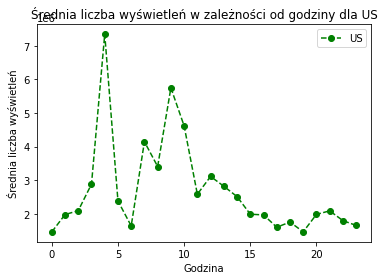

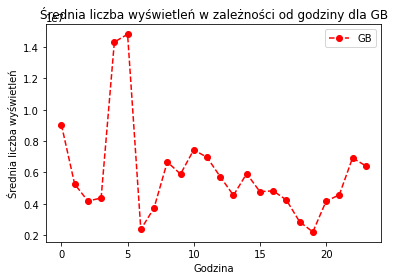

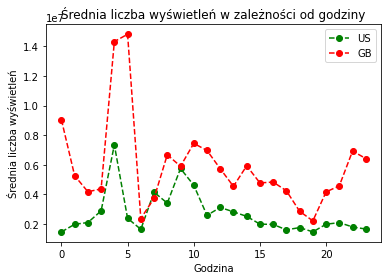

In [65]:
content['published_at_hour'] = content['publish_time'].dt.hour
by_hour_US = content[content['country_code'] == 'US'].groupby('published_at_hour').mean()
by_hour_GB = content[content['country_code'] == 'GB'].groupby('published_at_hour').mean()

def show_by_hour(df, name, color = 'green'):
    plt.plot(df.index.values, df['views'], marker='o', linestyle = '--', color=color, label = name)
    plt.xlabel('Godzina')
    plt.ylabel('Średnia liczba wyświetleń')
    plt.title('Średnia liczba wyświetleń w zależności od godziny dla ' + name)
    plt.legend()
    plt.show()

def show_by_hour_both(us, gb):
    plt.plot(us.index.values, us['views'], marker='o', linestyle = '--', color='green', label = 'US')
    plt.plot(gb.index.values, gb['views'], marker='o', linestyle = '--', color='red', label = 'GB')
    plt.xlabel('Godzina')
    plt.ylabel('Średnia liczba wyświetleń')
    plt.title('Średnia liczba wyświetleń w zależności od godziny')
    plt.legend()
    plt.show()

show_by_hour(by_hour_US, 'US')
show_by_hour(by_hour_GB, 'GB', color = 'red')
show_by_hour_both(by_hour_US, by_hour_GB)

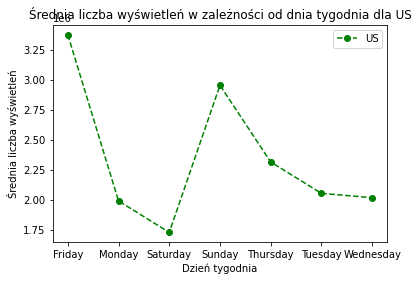

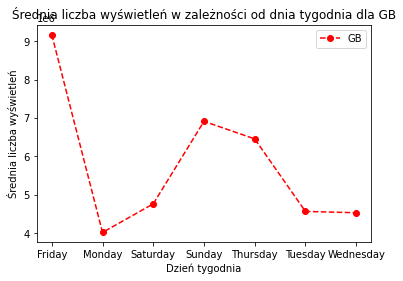

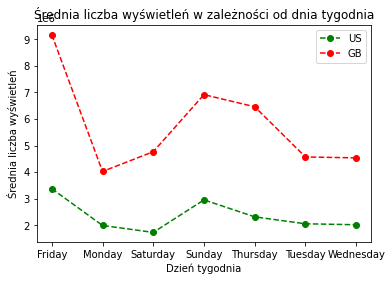

In [66]:
day_of_week_US = content[content['country_code'] == 'US'].groupby('published_day_of_week').mean()
day_of_week_GB = content[content['country_code'] == 'GB'].groupby('published_day_of_week').mean()

def show_day_of_week(df, name, color = 'green'):
    plt.plot(df.index.values, df['views'], marker='o', linestyle = '--', color=color, label = name)
    plt.xlabel('Dzień tygodnia')
    plt.ylabel('Średnia liczba wyświetleń')
    plt.title('Średnia liczba wyświetleń w zależności od dnia tygodnia dla ' + name)
    plt.legend()
    plt.show()

def show_day_of_week_both(us, gb):
    plt.plot(us.index.values, us['views'], marker='o', linestyle = '--', color='green', label = 'US')
    plt.plot(gb.index.values, gb['views'], marker='o', linestyle = '--', color='red', label = 'GB')
    plt.xlabel('Dzień tygodnia')
    plt.ylabel('Średnia liczba wyświetleń')
    plt.title('Średnia liczba wyświetleń w zależności od dnia tygodnia')
    plt.legend()
    plt.show()

show_day_of_week(day_of_week_US, 'US')
show_day_of_week(day_of_week_GB, 'GB', color = 'red')
show_day_of_week_both(day_of_week_US, day_of_week_GB)

Pojawienie się w zbiorze promowanych filmów (trending) jest na pewno pewnym osiągnięciem. Analizując zbiór danych natrafiliśmy na wielokrotne wystąpienie pewnych filmów i wskazanie, że utrzymywały się one dłużej niż jeden dzień w zestawieniu.

Postanowiliśmy sprawdzić jak wygląda rozkład długości przebywania filmu w ramach grupy trending.

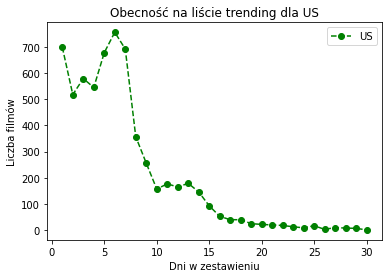

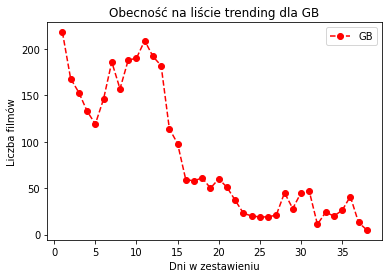

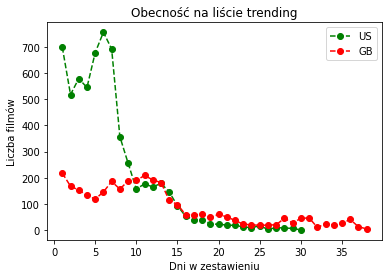

In [67]:
trending_time_US = content[(content['country_code'] == 'US') & (content['video_id'] != '#NAZWA?')].groupby('video_id')['video_id'].agg(count_col=pd.NamedAgg(column='video_id', aggfunc='count')).groupby('count_col').agg(days=pd.NamedAgg(column='count_col', aggfunc='count'))
trending_time_GB = content[(content['country_code'] == 'GB') & (content['video_id'] != '#NAZWA?')].groupby('video_id')['video_id'].agg(count_col=pd.NamedAgg(column='video_id', aggfunc='count')).groupby('count_col').agg(days=pd.NamedAgg(column='count_col', aggfunc='count'))

def show_trending_duration(df, name, color = 'green'):
    plt.plot(df.index.values, df['days'], marker='o', linestyle = '--', color=color, label = name)
    plt.xlabel('Dni w zestawieniu')
    plt.ylabel('Liczba filmów')
    plt.title('Obecność na liście trending dla ' + name)
    plt.legend()
    plt.show()

def show_trending_duration_both(us, gb):
    plt.plot(us.index.values, us['days'], marker='o', linestyle = '--', color='green', label = 'US')
    plt.plot(gb.index.values, gb['days'], marker='o', linestyle = '--', color='red', label = 'GB')
    plt.xlabel('Dni w zestawieniu')
    plt.ylabel('Liczba filmów')
    plt.title('Obecność na liście trending')
    plt.legend()
    plt.show()

show_trending_duration(trending_time_US, 'US')
show_trending_duration(trending_time_GB, 'GB', color = 'red')
show_trending_duration_both(trending_time_US, trending_time_GB)

Obserwujemy tutaj naprawdopodobniej błąd w zbiorze danych dostarczonych w zadaniu. Jako `video_id` pojawia się `#NAZWA?` zamiast poprawnego identyfikatora filmu. W dalszych etapach projektu będzie trzeba podjąć decyzję o przyszłości przykładów z tą wartością.

In [68]:
no_duplicated = content.drop_duplicates(subset='video_id', keep='first', inplace=False)
no_duplicated[no_duplicated['country_code'] == 'US'].select_dtypes(include=[np.bool]).apply(pd.Series.value_counts, normalize=True, dropna=False)

,comments_disabled,ratings_disabled,video_error_or_removed
False,0.983504,0.996018,0.999621
True,0.016496,0.003982,0.000379


In [69]:
no_duplicated[no_duplicated['country_code'] == 'GB'].select_dtypes(include=[np.bool]).apply(pd.Series.value_counts, normalize=True, dropna=False)

,comments_disabled,ratings_disabled,video_error_or_removed
False,0.983627,0.995057,0.998455
True,0.016373,0.004943,0.001545


In [70]:
content[content['country_code'] == 'US'].describe(percentiles=[0.05, 0.25, 0.50, 0.75, 0.95]).round(1)

,views,likes,dislikes,comment_count,likes_per_view,dislikes_per_views,likes_dislikes_ratio,comments_per_view,reactions_per_view,all_reactions_per_view,published_at_hour
count,40949.0,40949.0,40949.0,40949.0,40949.0,40949.0,40779.0,40949.0,40949.0,40949.0,40949.0
mean,2360784.6,74266.7,3711.4,8446.8,0.0,0.0,inf,0.0,0.0,0.0,13.8
std,7394113.8,228885.3,29029.7,37430.5,0.0,0.0,NaN,0.0,0.0,0.0,6.4
min,549.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5%,30390.0,316.0,22.0,49.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0
25%,242329.0,5424.0,202.0,614.0,0.0,0.0,13.4,0.0,0.0,0.0,10.0
50%,681861.0,18091.0,631.0,1856.0,0.0,0.0,29.3,0.0,0.0,0.0,15.0
75%,1823157.0,55417.0,1938.0,5755.0,0.0,0.0,57.1,0.0,0.0,0.1,18.0
95%,9017287.0,307402.6,11807.8,30783.0,0.1,0.0,138.3,0.0,0.1,0.1,22.0
max,225211923.0,5613827.0,1674420.0,1361580.0,0.3,0.2,inf,0.1,0.3,0.3,23.0


In [71]:
content[content['country_code'] == 'GB'].describe(percentiles=[0.05, 0.25, 0.50, 0.75, 0.95]).round(1)

,views,likes,dislikes,comment_count,likes_per_view,dislikes_per_views,likes_dislikes_ratio,comments_per_view,reactions_per_view,all_reactions_per_view,published_at_hour
count,38916.0,38916.0,38916.0,38916.0,38916.0,38916.0,38644.0,38916.0,38916.0,38916.0,38916.0
mean,5911943.6,134519.6,7612.6,13088.4,0.0,0.0,inf,0.0,0.0,0.0,12.9
std,19001210.0,349989.3,50956.8,50667.4,0.0,0.0,NaN,0.0,0.0,0.0,6.4
min,851.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5%,46630.2,648.0,26.0,72.0,0.0,0.0,3.6,0.0,0.0,0.0,1.0
25%,251527.2,5897.0,200.0,679.0,0.0,0.0,15.7,0.0,0.0,0.0,8.0
50%,981889.0,25182.5,821.0,2478.0,0.0,0.0,31.5,0.0,0.0,0.0,15.0
75%,3683628.5,114089.2,3357.5,9241.5,0.0,0.0,60.4,0.0,0.0,0.1,18.0
95%,24486574.8,564669.8,26920.2,50400.0,0.1,0.0,159.0,0.0,0.1,0.1,22.0
max,424538912.0,5613827.0,1944971.0,1626501.0,0.3,0.2,inf,0.1,0.3,0.3,23.0


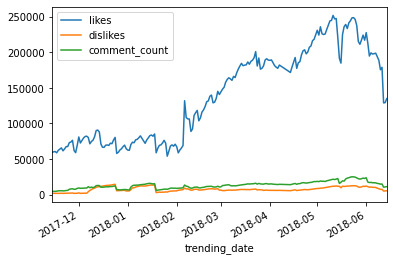

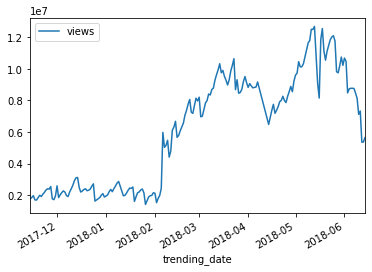

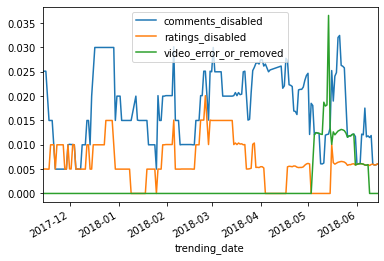

In [72]:
pivot_table = pd.pivot_table(content[content['country_code'] == 'GB'], index = content[content['country_code'] == 'GB'].trending_date)
_ = pivot_table[['likes','dislikes','comment_count']].plot()
_ = pivot_table[['views']].plot()
_ = pivot_table[['comments_disabled','ratings_disabled','video_error_or_removed']].plot()

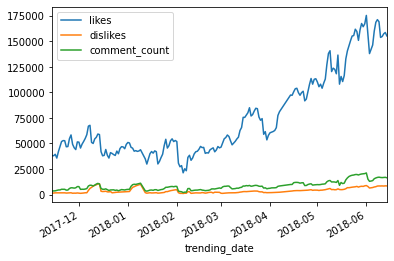

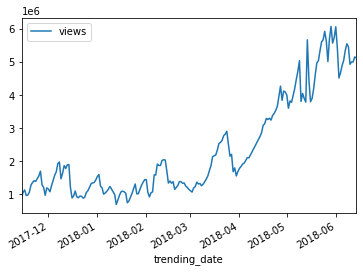

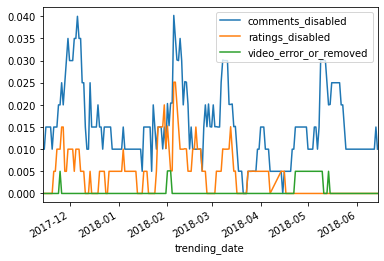

In [73]:
pivot_table = pd.pivot_table(content[content['country_code'] == 'US'], index = content[content['country_code'] == 'US'].trending_date)
_ = pivot_table[['likes','dislikes','comment_count']].plot()
_ = pivot_table[['views']].plot()
_ = pivot_table[['comments_disabled','ratings_disabled','video_error_or_removed']].plot()

In [0]:
def plt_word_cloud(data):
    wc = WordCloud(width=1200, height=500, collocations=False).generate(" ".join(data))
    plt.figure(figsize=(15,10))
    plt.imshow(wc, interpolation='bilinear')
    _ = plt.axis("off")

def frequency_words(df, n=100):
    lower_title = df.str.lower().str.cat(sep=' ')
    only_words = re.sub('[^A-Za-z]+', ' ', lower_title)
    stop_words = set(stopwords.words('english'))

    word_tokens = word_tokenize(only_words)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]

    words_without_single_character = [word for word in filtered_sentence if len(word) > 2]
    no_numeric = [word for word in words_without_single_character if not word.isnumeric()]

    word_dist = nltk.FreqDist(no_numeric)
    rslt = pd.DataFrame(word_dist.most_common(n), columns=['word', 'freq'])

    plt.figure(figsize=(20, 10))
    plt.xticks(rotation=90)
    ax = sns.barplot(x='word', y='freq', data=rslt.head(int(n/2))).set(
      xlabel='Słowo', 
      ylabel='Ilość wystąpień'
    )

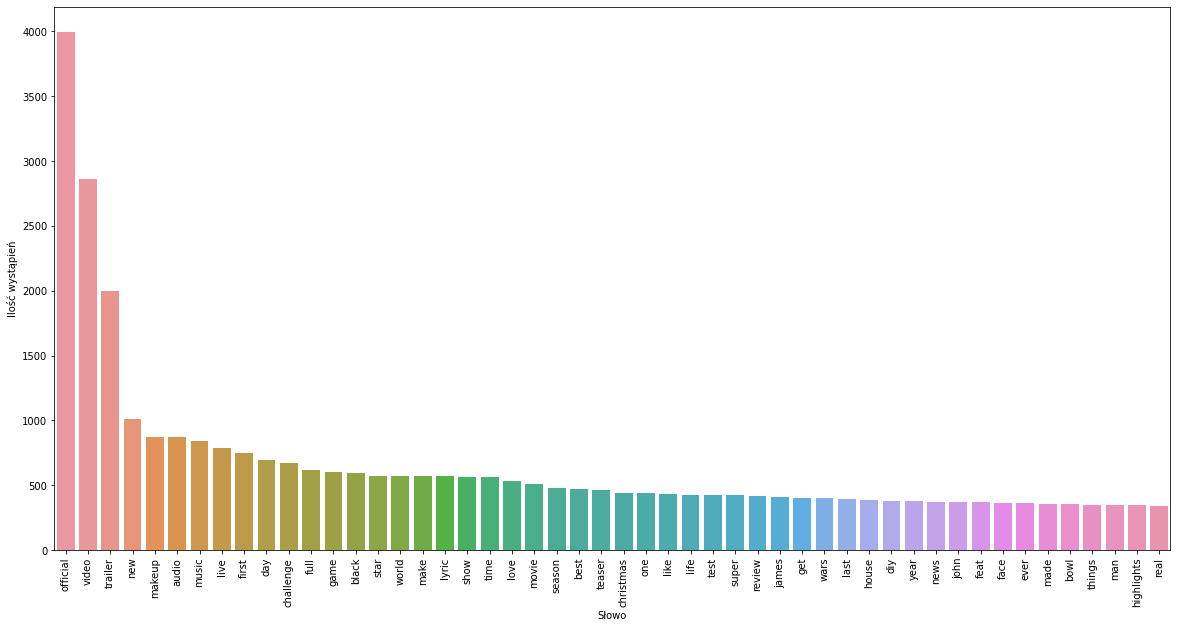

In [75]:
frequency_words(content[content['country_code'] == 'US']['title'])

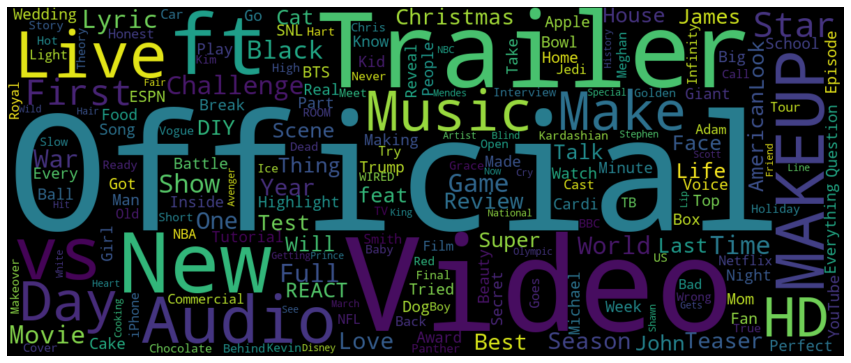

In [76]:
plt_word_cloud(content[content['country_code'] == 'US']['title'])

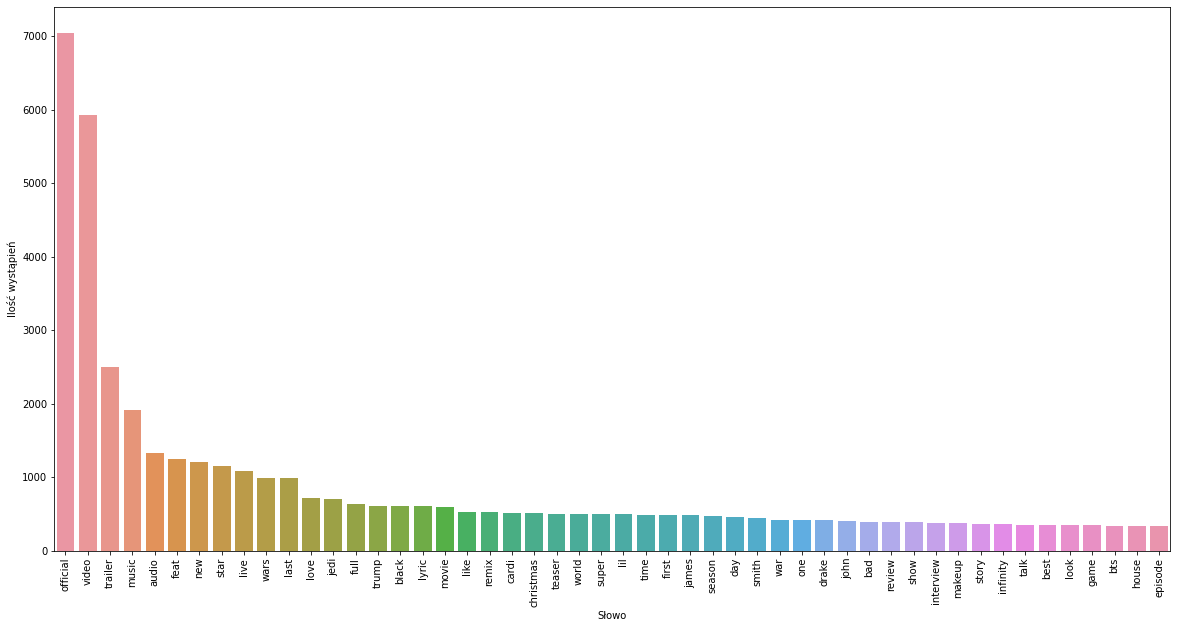

In [77]:
frequency_words(content[content['country_code'] == 'GB']['title'])

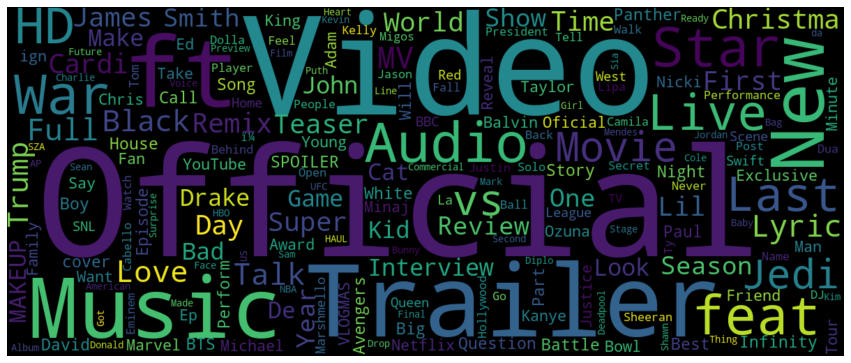

In [78]:
plt_word_cloud(content[content['country_code'] == 'GB']['title'])

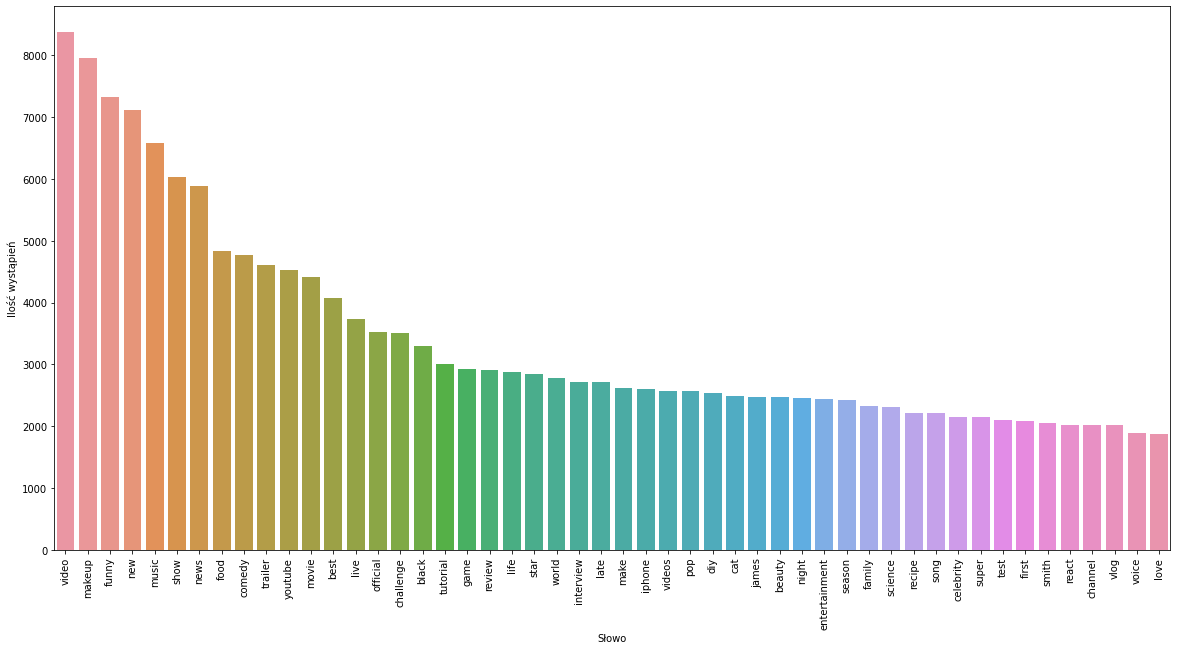

In [79]:
frequency_words(content[content['country_code'] == 'US']['tags'])

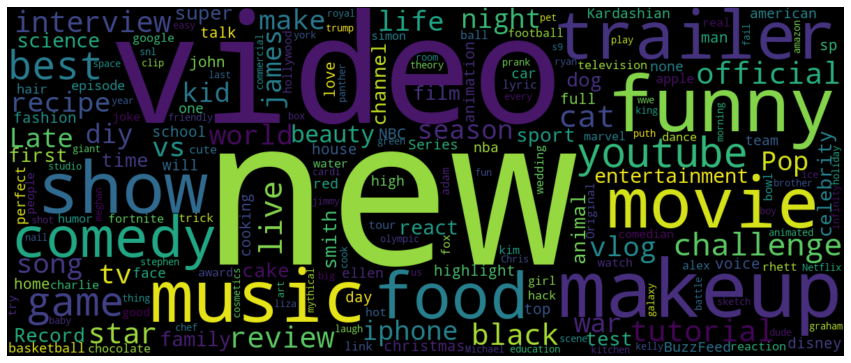

In [80]:
plt_word_cloud(content[content['country_code'] == 'US']['tags'])

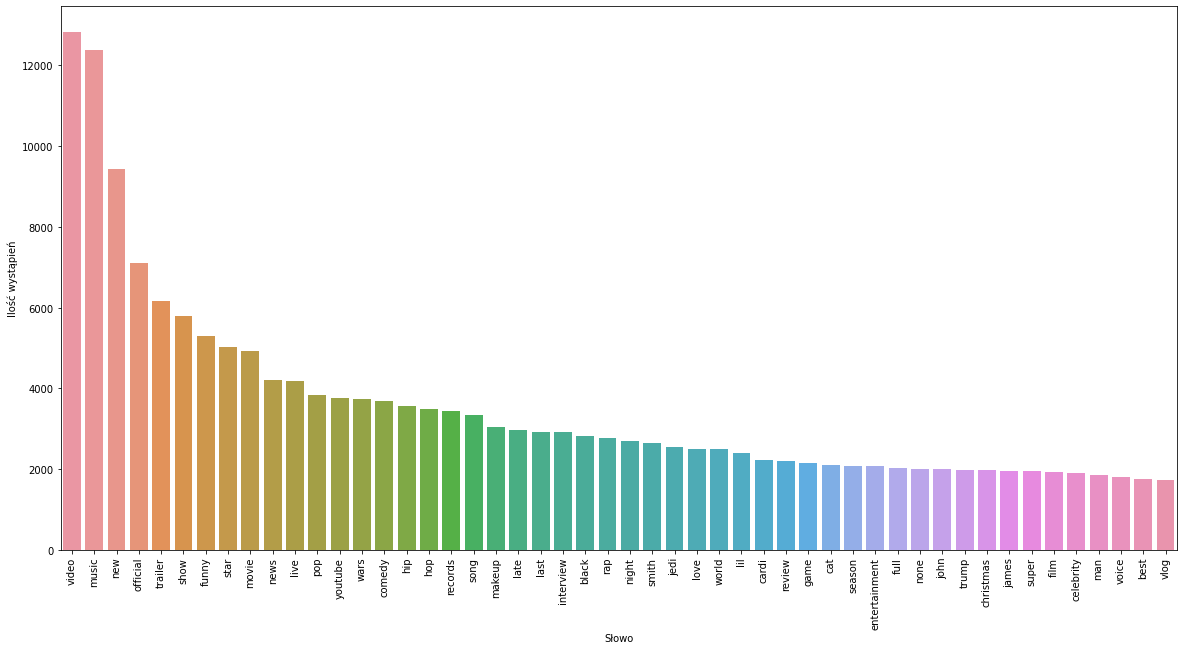

In [81]:
frequency_words(content[content['country_code'] == 'GB']['tags'])

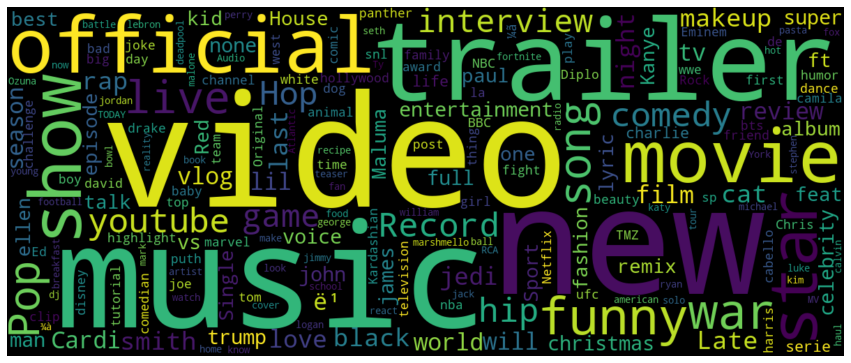

In [82]:
plt_word_cloud(content[content['country_code'] == 'GB']['tags'])

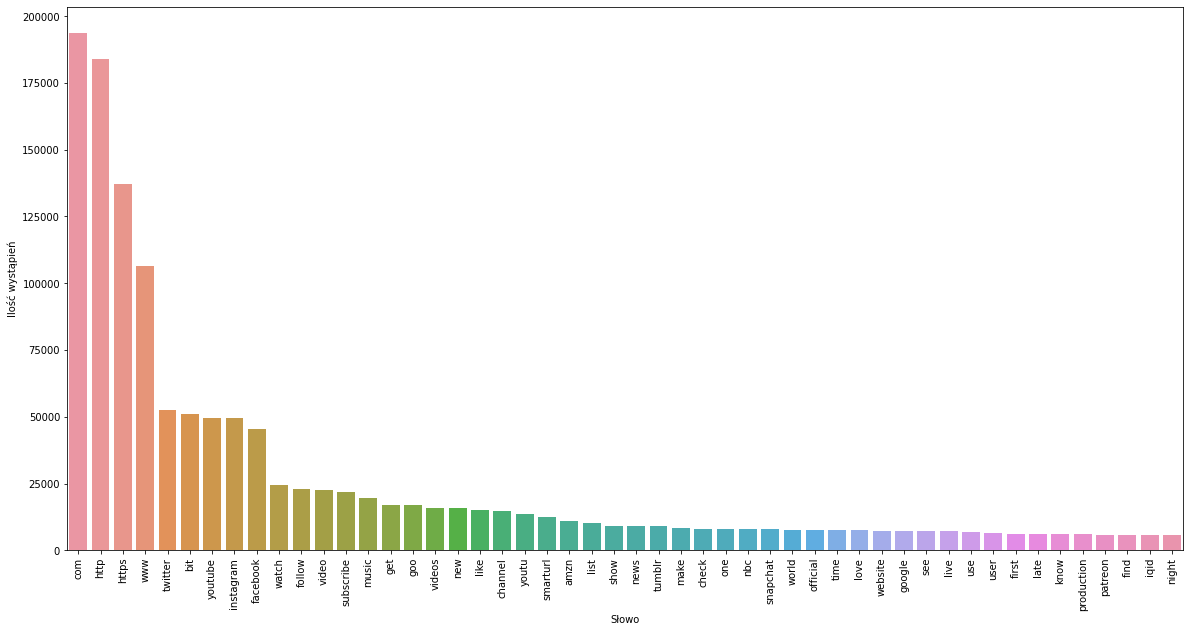

In [83]:
frequency_words(content[content['country_code'] == 'US']['description'])

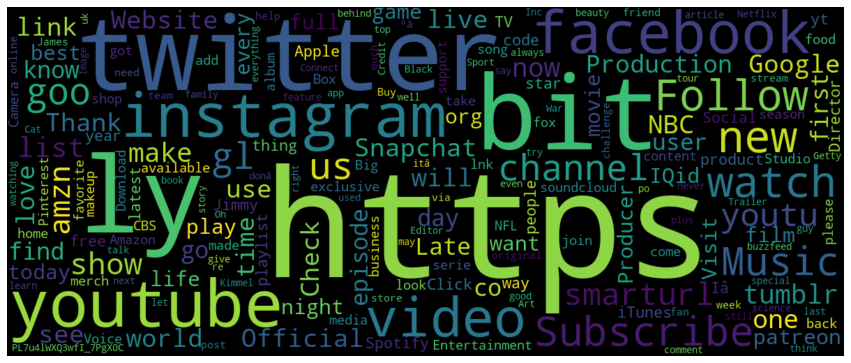

In [84]:
plt_word_cloud(content[content['country_code'] == 'US']['description'])

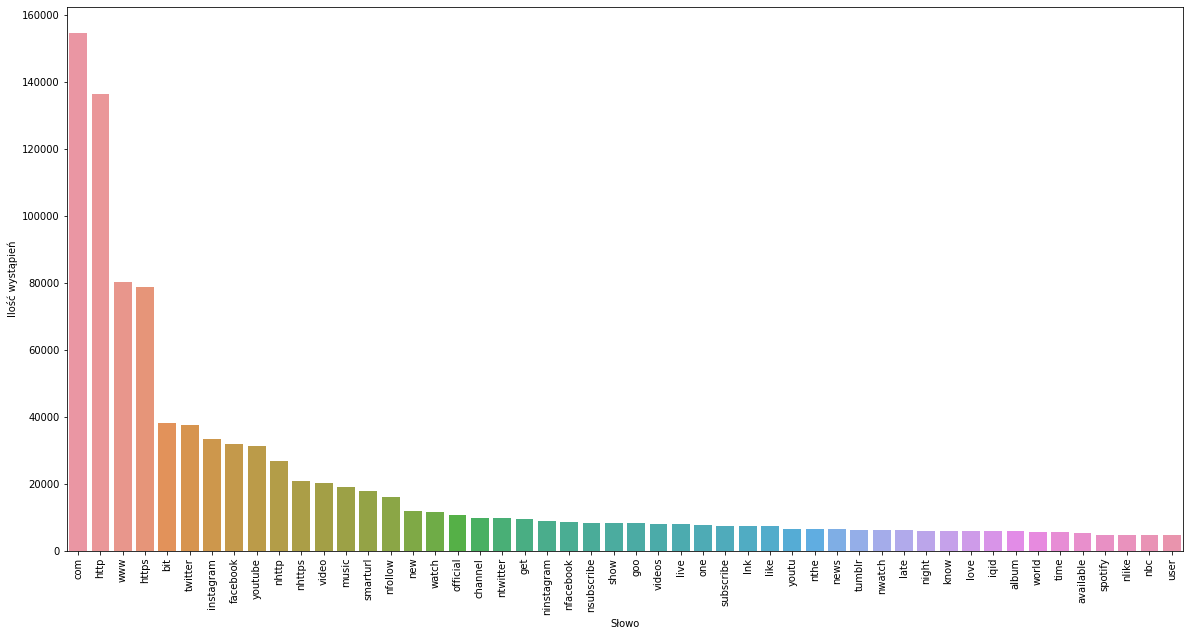

In [85]:
frequency_words(content[content['country_code'] == 'GB']['description'])

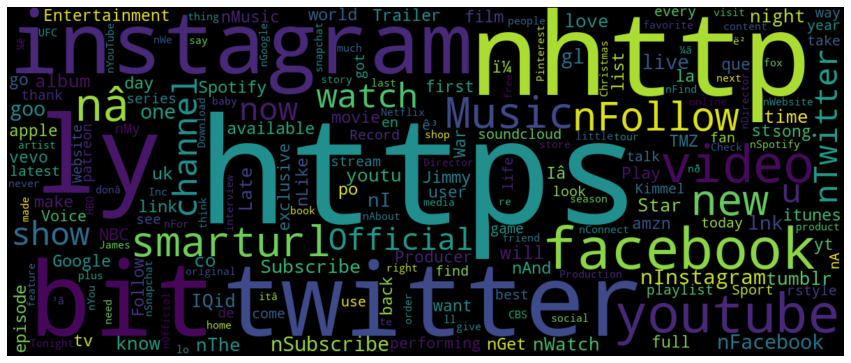

In [86]:
plt_word_cloud(content[content['country_code'] == 'GB']['description'])

In [87]:
content[content['country_code'] == 'US'].trending_date.describe()

count                   40949
unique                    205
top       2017-12-27 00:00:00
freq                      200
first     2017-11-14 00:00:00
last      2018-06-14 00:00:00
Name: trending_date, dtype: object

In [88]:
content[content['country_code'] == 'GB'].trending_date.describe()

count                   38916
unique                    205
top       2017-12-27 00:00:00
freq                      200
first     2017-11-14 00:00:00
last      2018-06-14 00:00:00
Name: trending_date, dtype: object

In [89]:
TODO: wskazanie okresu że święta i mogą być dane z tego okresu

SyntaxError: ignored

In [0]:
def show_correlation(df):
    plt.figure(figsize = (20, 10))
    sns.heatmap(df.corr(), annot=True)
    plt.show()

In [0]:
show_correlation(content[content['country_code'] == 'US'])

In [0]:
show_correlation(content[content['country_code'] == 'GB'])

Dokonując analizy danych nie sposób nie wskazać pewnych oczekiwanych, brakujących danych. W naszym przypadku doszliśmy do wniosku o możliwym pozytywnym wpływie danych w postaci:
*   Długość materiału video przesłanego przez użytkownika. Spodziewamy się, że materiały mające długość w zakresie od 3 do 10 min powinny dominować w zbiorze trending videos.
*  Data publikacji a sezonowość. W przypadku świąt jak chociażby Święta Bożego Narodzenia lub Święto Dziękczynienia w USA, video nawiązujące do wskazanego tematu najprawdopodobniej będą dominować zbiór trending videos. Na to przekłada się również sezonowość użytych tagów.

Ponadto, dysponujemy wyłącznie zbiorem danych wskazującym na filmy oznaczone jako trending. Brakuje nam informacji w postaci zbioru danych dla filmów, które nie zostały w tej sposób wyróżnione, aby móc jasno wskazać różnice pomiędzy nimi.

---
# TUTAJ MAM KONIEC

In [0]:
# Basic analysis All

# GB_videos_5p
print('GB_videos_5p\n')
print('number of attributes: ', len(GB_videos_5p.columns))
print('attributes names: ', GB_videos_5p.columns)
for n in GB_videos_5p.columns:
  print('not empty attribute', n, '[%]:', 100 * len(GB_videos_5p[GB_videos_5p[n].notnull()]) / len(GB_videos_5p))
print(GB_videos_5p.describe())

# US_videos_5p
print('\n\nUS_videos_5p\n')
print('number of attributes: ', len(US_videos_5p.columns))
print('attributes names: ', US_videos_5p.columns)
for n in US_videos_5p.columns:
  print('not empty attribute', n, '[%]:', 100 * len(US_videos_5p[US_videos_5p[n].notnull()]) / len(US_videos_5p))
print(US_videos_5p.describe())

In [0]:
print('GB_videos_5p less than 1 million views:', GB_videos_5p[GB_videos_5p['views'] < 1e6]['views'].count() / GB_videos_5p['views'].count() * 100)
print('US_videos_5p less than 1 million views:', US_videos_5p[US_videos_5p['views'] < 1e6]['views'].count() / US_videos_5p['views'].count() * 100)

# GB_videos_5p
print('LIKES:')
plt.rc('figure.subplot', wspace=0.9)
fig, ax = plt.subplots()
_ = sns.distplot(GB_videos_5p["likes"], kde=False, 
                 hist_kws={'alpha': 1}, 
                 bins=np.linspace(0, 6e6, 61), ax=ax)
_ = ax.set(xlabel="Likes", ylabel="No. of videos GB_videos_5p")
_ = plt.xticks(rotation=90)

# US_videos_5p
plt.rc('figure.subplot', wspace=0.9)
fig, ax = plt.subplots()
_ = sns.distplot(US_videos_5p["likes"], kde=False, 
                 hist_kws={'alpha': 1}, 
                 bins=np.linspace(0, 6e6, 61), ax=ax)
_ = ax.set(xlabel="Likes", ylabel="No. of videos US_videos_5p")
_ = plt.xticks(rotation=90)

In [0]:
GB_videos_5p["title_length"] = GB_videos_5p["title"].apply(lambda x: len(x))
fig, ax = plt.subplots()
_ = sns.distplot(GB_videos_5p["title_length"], kde=False, rug=False, 
                 hist_kws={'alpha': 1}, ax=ax)
_ = ax.set(xlabel="Title Length", ylabel="No. of videos GB_videos_5p", xticks=range(0, 110, 10))

US_videos_5p["title_length"] = US_videos_5p["title"].apply(lambda x: len(x))
fig, ax = plt.subplots()
_ = sns.distplot(US_videos_5p["title_length"], kde=False, rug=False, 
                 hist_kws={'alpha': 1}, ax=ax)
_ = ax.set(xlabel="Title Length", ylabel="No. of videos US_videos_5p", xticks=range(0, 110, 10))

fig, ax = plt.subplots()
_ = ax.scatter(x=GB_videos_5p['views'], y=GB_videos_5p['title_length'], linewidths=0.5)
_ = ax.set(xlabel="Views", ylabel="Title Length")

fig, ax = plt.subplots()
_ = ax.scatter(x=US_videos_5p['views'], y=US_videos_5p['title_length'], linewidths=0.5)
_ = ax.set(xlabel="Views", ylabel="Title Length")

1. Mediana wyświetleń to 681 861, a średnia 2 360 785, czyli znaczna większość filmów ma dużo mniej wyświetleń niż średnia. Wniosek: po przejściu pewnej granicy wyświetleń ich liczba znacznie wzrasta. Liczba wyświetleń rośnie nieproporcjonalnie do popularności. 
2. Podobna sytuacja jest przy komentarzach. Niektóre filmy są dużo chętniej komentowane. Podobnie przy polubieniach.
3. Wbrew pozorom popularności hejtów, średnio "łapek w górę" jest 20 razy więcej niż w dół.

In [0]:
# date analysis

# GB_videos_5p
new_date_GB = GB_videos_5p.copy()
new_date_GB['trending_date'] = pd.to_datetime(GB_videos_5p['trending_date'],errors='coerce', format='%y.%d.%m')
new_date_GB['publish_time'] = pd.to_datetime(GB_videos_5p['publish_time'], errors='coerce', format='%Y-%m-%dT%H:%M:%S.%fZ')

new_date_GB = new_date_GB[new_date_GB['trending_date'].notnull()]
new_date_GB = new_date_GB[new_date_GB['publish_time'].notnull()]

new_date_GB = new_date_GB.dropna(how='any',inplace=False, axis = 0)

new_date_GB.insert(4, 'publish_date', new_date_GB['publish_time'].dt.date)
new_date_GB['publish_time'] = new_date_GB['publish_time'].dt.time

new_date_GB_full = new_date_GB.reset_index().sort_values('trending_date').set_index('video_id')
new_date_GB = new_date_GB.reset_index().sort_values('trending_date').drop_duplicates('video_id',keep='last').set_index('video_id')
print('new_date_GB publish date range:')
print(new_date_GB[['publish_date','publish_time']])

cdf = GB_videos_5p["trending_date"].apply(lambda x: '20' + x[:2]).value_counts() \
            .to_frame().reset_index() \
            .rename(columns={"index": "year", "trending_date": "No_of_videos"})
fig, ax = plt.subplots()
_ = sns.barplot(x="year", y="No_of_videos", data=cdf, 
                palette=sns.color_palette(['#ff764a', '#ffa600'], n_colors=7), ax=ax)
_ = ax.set(xlabel="Year", ylabel="No. of videos GB_videos_5p")

# US_videos_5p
new_date_US = US_videos_5p.copy()
new_date_US['trending_date'] = pd.to_datetime(new_date_US['trending_date'],errors='coerce', format='%y.%d.%m')
new_date_US['publish_time'] = pd.to_datetime(new_date_US['publish_time'], errors='coerce', format='%Y-%m-%dT%H:%M:%S.%fZ')

new_date_US = new_date_US[new_date_US['trending_date'].notnull()]
new_date_US = new_date_US[new_date_US['publish_time'].notnull()]

new_date_US = new_date_US.dropna(how='any',inplace=False, axis = 0)

new_date_US.insert(4, 'publish_date', new_date_US['publish_time'].dt.date)
new_date_US['publish_time'] = new_date_US['publish_time'].dt.time

new_date_US_full = new_date_US.reset_index().sort_values('trending_date').set_index('video_id')
new_date_US = new_date_US.reset_index().sort_values('trending_date').drop_duplicates('video_id',keep='last').set_index('video_id')
print('new_date_US publish date range:')
print(new_date_US[['publish_date','publish_time']])

cdf = US_videos_5p["trending_date"].apply(lambda x: '20' + x[:2]).value_counts() \
            .to_frame().reset_index() \
            .rename(columns={"index": "year", "trending_date": "No_of_videos"})
fig, ax = plt.subplots()
_ = sns.barplot(x="year", y="No_of_videos", data=cdf, 
                palette=sns.color_palette(['#ff764a', '#ffa600'], n_colors=7), ax=ax)
_ = ax.set(xlabel="Year", ylabel="No. of videos US_videos_5p")